# Part 1: Unsupervised Domain Adaptation (UDA) on MNIST

## 0. Introduction

Domain Adaptation is a technique to improve the performance of a model on a target domain containing insufficient annotated data by using the knowledge learned by the model from another related domain with adequate labeled data. The mechanism of domain adaptation is to uncover the common latent factors across the source and target domains and adapt them to reduce the difference in terms of the feature space between domains. 

- Labeled training data from a source domain:
\begin{equation}
\mathcal{D}_s=\left\{\left(\mathbf{x}_s^1, \mathbf{y}_s^1\right), \ldots,\left(\mathbf{x}_s^m, \mathbf{y}_s^m\right)\right\}, \mathbf{y}_s^i \in Y
\end{equation}
- Unlabeld date from a target domain:
\begin{equation}
\mathcal{D}_t=\left\{\mathrm{x}_t^1, \ldots, \mathrm{x}_t^n\right\}
\end{equation}
- Test data from the same target domain:
\begin{equation}
\mathcal{D}_{\text {test }}=\left\{\mathbf{x}_{\text {test }}^1, \ldots, \mathbf{x}_{\text {test }}^o\right\}
\end{equation}

## 1. MNIST Dataset

The MNIST database is a large database of handwritten digits, which is commonly used for the image classification task. The goal here is to classify the digit in each image. For our exercise, we take MNIST and its colorful variation MNIST-M to train the domain adaptation task:
- Source domain: MNIST
- Target domain: MNIST-M, a colored and textured version of MNIST


**NOTE**: Make sure you have downloaded the datasets and extracted them properly at the right location during setup.

In [ ]:
%matplotlib inline

import os

import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as tvtf
import torch.optim as optim
from tqdm import tqdm

from utils.data import MNISTMDataset
from utils.utils import test

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


In [ ]:
# Hyperparameters
image_size = 28
batch_size = 64

# import source & target dataset
tf_source = tvtf.Compose(
    [
        tvtf.Resize(image_size),
        tvtf.ToTensor(),
        tvtf.Normalize(mean=(0.1307,), std=(0.3081,)),
    ]
)
tf_target = tvtf.Compose(
    [
        tvtf.Resize(image_size),
        tvtf.ToTensor(),
        tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

# train dataLoader
ds_source = tv.datasets.MNIST(
    root="../datasets/mnist_dataset/", train=True, transform=tf_source, download=True
)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

ds_target = MNISTMDataset(
    os.path.join("../datasets/mnist_dataset/mnist_m", "mnist_m_train"),
    os.path.join("../datasets/mnist_dataset/mnist_m", "mnist_m_train_labels.txt"),
    transform=tf_target,
)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# test dataLoader
ds_test_source = tv.datasets.MNIST(
    root="../datasets/mnist_dataset/", train=False, transform=tf_source, download=True
)
dl_test_source = torch.utils.data.DataLoader(ds_test_source, batch_size)

ds_test_target = MNISTMDataset(
    os.path.join("../datasets/mnist_dataset/mnist_m/", "mnist_m_test"),
    os.path.join("../datasets/mnist_dataset/mnist_m/", "mnist_m_test_labels.txt"),
    transform=tf_target,
)
dl_test_target = torch.utils.data.DataLoader(ds_test_target, batch_size)


In [ ]:
# check example data from MNIST & MNIST-M
from utils.utils import dataset_first_n

dataset_first_n(ds_source, 3, cmap="gray")
dataset_first_n(ds_target, 3)


## 2. Baseline Network (without domain adaptation)

In [ ]:
class CNN(nn.Module):
    """Small Convolutional Neural Network for MNIST image classification"""

    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)

        # feature extractor
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)

        # classification head
        class_pred = self.class_classifier(features)

        return class_pred, features


In [ ]:
# Training hyperparameters
learning_rate = 1e-3
epochs_count = 2

# model, optimizer & loss function
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), learning_rate)
loss_fn_class = torch.nn.NLLLoss()


In [ ]:
# dataloader
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_test_source = torch.utils.data.DataLoader(ds_test_source, batch_size)
dl_test_target = torch.utils.data.DataLoader(ds_test_target, batch_size)


In [ ]:
# training
training_loss = 0
for epoch_idx in range(epochs_count):
    model.train()
    print(f"Epoch {epoch_idx+1:04d} / {epochs_count:04d}", end="\n=================\n")
    dl_source_iter = iter(dl_source)

    for batch_idx in tqdm(range(len(dl_source))):
        optimizer.zero_grad()
        # Train on source domain
        X_s, y_s = next(dl_source_iter)

        class_pred, _ = model(X_s.to(device))

        loss = loss_fn_class(class_pred, y_s.to(device))
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(
        f"[{epoch_idx+1}/{epochs_count}] "
        f"class_loss: {training_loss/len(dl_source):.4f} "
    )
    training_loss = 0
    model.eval()
    print("Accuracy on SOURCE test dataset:", end=" ")
    test(model, dl_test_source, device)
    print("Accuracy on TARGET test dataset:", end=" ")
    test(model, dl_test_target, device)


Here we could see a large performance drop on the target MINIST-M dataset with a different distribution.

Now let's go for 3 main research branches in domain adaptation field. Each method forces the model to learn invariant features of the source & target domain by adding the constraint in different ways.

## 3. AdaBN Method

### 3.1 Recap: Batch Normalization

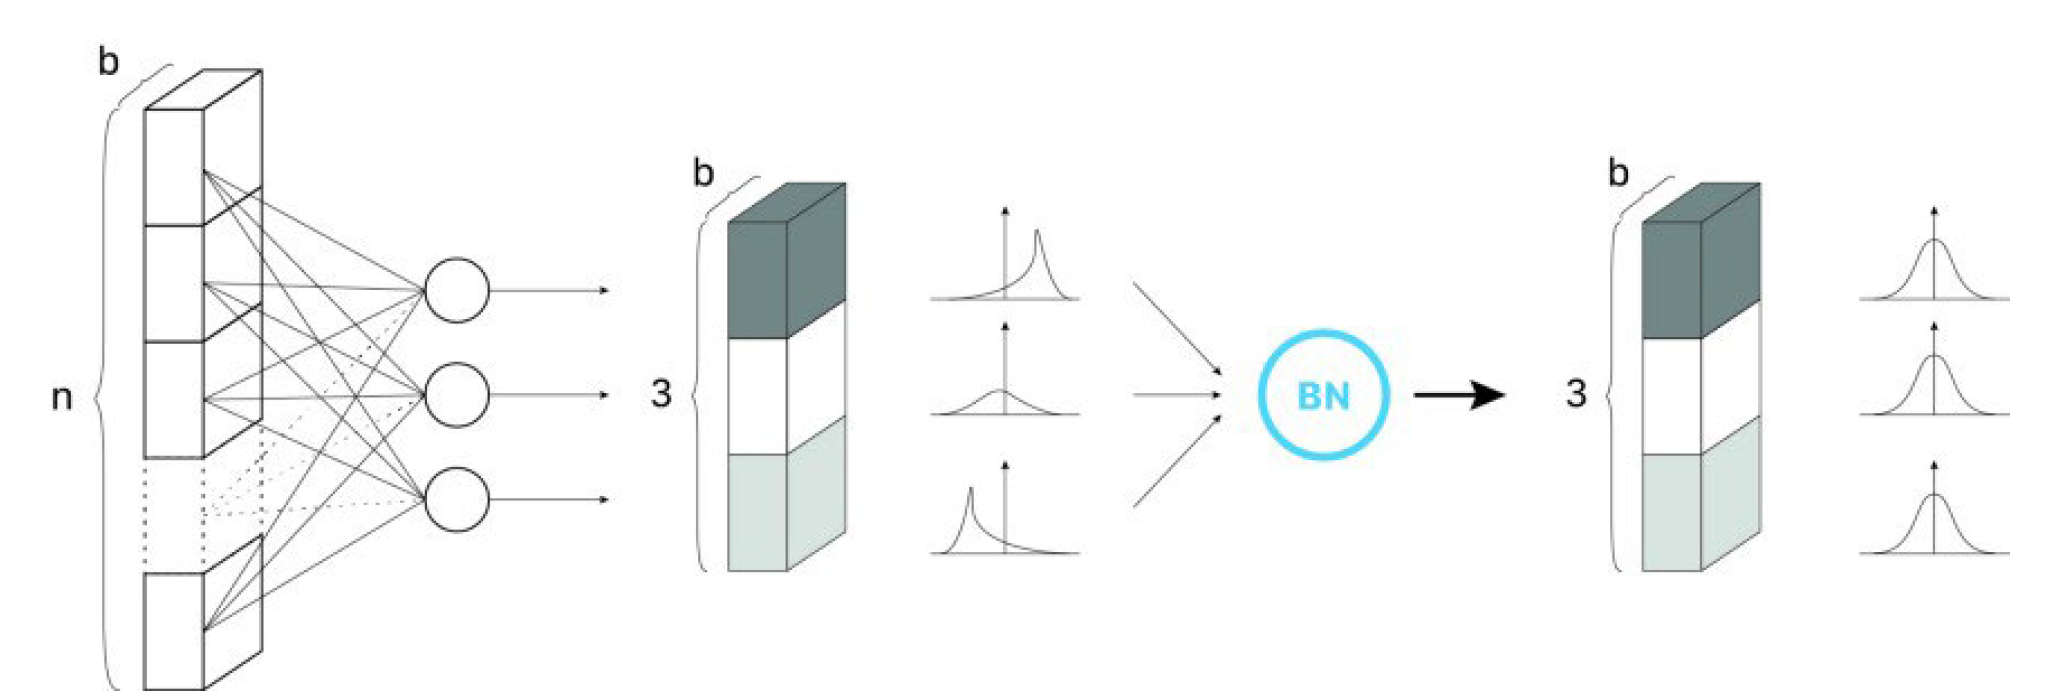

\begin{equation}
\begin{aligned}
\hat{x_j} &=\frac{x_j-\mathbb{E}\left[x_{\cdot j}\right]}{\sqrt{\operatorname{Var}\left[x_{\cdot j}\right]}} \\
y_j &=\gamma_j \hat{x_j}+\beta_j
\end{aligned}
\end{equation}

### 3.2 Recap: AdaBN

<div>
<img src="media/adabn.jpg" width="700"/>
</div>
<font size="1"><i><center>Li, Yanghao, et al. "Adaptive batch normalization for practical domain adaptation." Pattern Recognition 80 (2018): 109-117.</center></i></font>

The domain specific normalization mitigates the domain shift issue by learning the appropriate parameter to align the different distribution of the source & target domain.

Now let's adapt the baseline model with AdaBN. To do this, we need to load the unlabeled dataset for training.

In [ ]:
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)


To implement AdaBN, we adapt the previous baseline model with the unlabeled target dataset, replacing the Batch Normalization parameters with new values computed from the target domain. This could be achieved by simply set the $track\_running\_stats$ of the BatchNormalization layers to <strong>True</strong> while not changing other parts of the network trained with labeled source data. During training, this parameter is set to True and the BatchNormalization layers keeps running estimates of the computed mean and variance, which are then used for normalization during evaluation. If $track\_running\_stats$ is set to False, this layer then does not keep running estimates, and batch statistics are instead used during evaluation time as well. [more information on BatchNormalization2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

In [ ]:
for epoch_idx in range(epochs_count):
    model.train()
    print(f"Epoch {epoch_idx+1:04d} / {epochs_count:04d}", end="\n=================\n")
    dl_target_iter = iter(dl_target)

    for batch_idx in tqdm(range(len(dl_target))):
        optimizer.zero_grad()
        X_t, _ = next(dl_target_iter)  # ignore target domain class labels!

        # use unlabeled target domain data to recompute global mean & variance of Batch Normalization Layers
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                # TODO: IMPLEMENTATION HERE
                m.track_running_stats = ?

        class_pred, _ = model(X_t.to(device))

    print(f"[{epoch_idx+1}/{epochs_count}] ")
    print("Accuracy on SOURCE test dataset:", end=" ")
    test(model, dl_test_source, device)
    print("Accuracy on TARGET test dataset:", end=" ")
    test(model, dl_test_target, device)


## 4. Discrepancy-based Method

Discrepancy-based methods aim to minimizes the discrepancy between domain-specific latent feature representations directly in the hidden activation space. 

<div>
<img src="media/cmd.png", width="700"/>
</div>
<font size="1"><i><center>Zellinger, Werner, et al. "Central moment discrepancy (cmd) for domain-invariant representation learning." arXiv preprint arXiv:1702.08811 (2017).</center></i></font>

Different methods compute the distance between features differently. The computed feature discrepancy are backpropogated as loss function to enforce the model to learn features that are more similar between the source and target domain.

### 4.1 Maximum Mean Dicrepancy
Given $X,Y$ maximum mean discrepancy is the distance between feature means of $X \sim P$ and $Y \sim Q$:

$$ MMD^{2}(P,Q) = \Vert \mu_{P} - \mu_{Q} \Vert^{2} _{\mathcal{F}} \tag{3} $$

In real life settings we don't have access to the underlying distribution $P$ and $Q$ of our data. For this reason, for implementation, we develop the approximation of the previous equation from sample as:

$$ MMD^{2}(X,Y) = \underbrace{\frac{1}{m (m-1)} \sum_{i} \sum_{j \neq i} k(\mathbf{x_{i}}, \mathbf{x_{j}})}_\text{A} - \underbrace{2 \frac{1}{m.m} \sum_{i} \sum_{j} k(\mathbf{x_{i}}, \mathbf{y_{j}})}_\text{B} + \underbrace{\frac{1}{m (m-1)} \sum_{i} \sum_{j \neq i} k(\mathbf{y_{i}}, \mathbf{y_{j}})}_\text{C} \tag{5} $$

Now let's go for the implementation of this MMD method. Here we use the Gaussion Kernel for distribution esitimation

In [ ]:
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0]) + int(target.size()[0])
    total = torch.cat([source, target], dim=0)

    total0 = total.unsqueeze(0).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1))
    )
    total1 = total.unsqueeze(1).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1))
    )
    L2_distance = ((total0 - total1) ** 2).sum(2)
    # print(L2_distance)

    bandwidth = torch.sum(L2_distance.data) / (n_samples**2 - n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [
        torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list
    ]
    return sum(kernel_val)


Now we define MMD loss as follow:

In [ ]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        # return

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = gaussian_kernel(
            source,
            target,
            kernel_mul=self.kernel_mul,
            kernel_num=self.kernel_num,
            fix_sigma=self.fix_sigma,
        )
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY - YX)
        return loss


In [ ]:
# initilization as usual
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), learning_rate)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = MMD_loss()

# load dataset
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))


In [ ]:
# training
training_loss = 0
training_loss_domain = 0
training_loss_class = 0
for epoch_idx in range(epochs_count):
    print(f"Epoch {epoch_idx+1:04d} / {epochs_count:04d}", end="\n=================\n")
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in tqdm(range(max_batches)):
        optimizer.zero_grad()

        # Train on source domain
        X_s, y_s = next(dl_source_iter)

        # Train on target domain
        X_t, _ = next(dl_target_iter)  # ignore target domain class labels!

        batch_size = min(X_s.shape[0], X_t.shape[0])

        class_pred, feature_s = model(X_s[:batch_size, :].to(device))
        loss_s_label = loss_fn_class(class_pred, y_s[:batch_size].to(device))

        _, feature_t = model(X_t[:batch_size, :].to(device))

        # TODO: IMPLEMENTATION HERE
        loss_domain = loss_fn_domain(?)
        loss = ?

        training_loss += loss.item()
        training_loss_domain += loss_domain.item()
        training_loss_class += loss_s_label.item()

        loss.backward()
        optimizer.step()

    print(
        f"[{epoch_idx+1}/{epochs_count}] "
        f"class_loss: {training_loss_class/len(dl_source):.4f} "
        f"domain_loss: {training_loss_domain/len(dl_source):.4f} "
        f"total_loss: {training_loss/len(dl_source):.4f} "
    )
    training_loss = 0
    model.eval()
    print("Accuracy on SOURCE test dataset:", end=" ")
    test(model, dl_test_source, device)
    print("Accuracy on TARGET test dataset:", end=" ")
    test(model, dl_test_target, device)


## 5. Adversarial-based Method

### 5.1 Recap: Adversarial Domain Adaptation
<div>
   <img src="media/uad_backprop.png", width="700"/>
</div>
<font size="1"><i><center>Ganin, Yaroslav, and Victor Lempitsky. "Unsupervised domain adaptation by backpropagation." International conference on machine learning. PMLR, 2015.</center></i></font>


First, we define Gradient Reverse Layer(GRL) Layer, which is required for backpropogate the reverse gradient of the domain discriminator. [more information on GRL](https://arxiv.org/pdf/1409.7495.pdf)

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # store context for backprop
        ctx.alpha = alpha
        # forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None


Next step is to defne the network with 3 components: feature extractor, common classifier and domain classifier. The first two are like what we did for the baseline model. A discriminator is defined in addition.

In [ ]:
class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        # domain classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)

        class_pred = self.class_classifier(features)
        # TODO: IMPLEMENTATION HERE
        domain_pred = ?
        return class_pred, domain_pred


A common trick here: in order to help stablize the training process of the adversarial network, we introduce a learning rate scheduler, which reduces the learning rate as the training proceed.

In [ ]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group["lr"] = 0.01 / (1.0 + 10 * p) ** 0.75

    return optimizer


In [ ]:
learning_rate = 1e-2
epochs_count = 5

# Setup optimizer as usual
model = DANN().to(device)
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))


In [ ]:
# training
training_loss = 0
training_loss_domain = 0
training_loss_class = 0
p = 0

for epoch_idx in range(epochs_count):
    print(f"Epoch {epoch_idx+1:04d} / {epochs_count:04d}", end="\n=================\n")
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in tqdm(range(max_batches)):
        model.train()
        optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (epochs_count * max_batches)
        grl_lambda = 2.0 / (1.0 + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        # Train on target domain
        X_t, _ = next(dl_target_iter)  # ignore target domain class labels!
        batch_size = min(X_s.shape[0], X_t.shape[0])

        y_s_domain = torch.zeros(batch_size, dtype=torch.long).to(
            device
        )  # generate source domain labels
        y_t_domain = torch.ones(batch_size, dtype=torch.long).to(
            device
        )  # generate target domain labels

        class_pred, domain_pred = model(X_s[:batch_size].to(device), grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s[:batch_size].to(device))
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        _, domain_pred = model(X_t.to(device), grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)

        loss = loss_t_domain + loss_s_domain + loss_s_label

        training_loss += loss.item()
        training_loss_domain += (loss_t_domain + loss_s_domain).item()
        training_loss_class += loss_s_label.item()

        loss.backward()
        optimizer.step()

    print(
        f"[{epoch_idx+1}/{epochs_count}] "
        f"class_loss: {training_loss_class/len(dl_source):.4f} "
        f"domain_loss: {training_loss_domain/len(dl_source):.4f} "
        f"total_loss: {training_loss/len(dl_source):.4f} "
    )
    training_loss = 0
    training_loss_domain = 0
    training_loss_class = 0
    model.eval()
    print("Accuracy on SOURCE test dataset:", end=" ")
    test(model, dl_test_source, device)
    print("Accuracy on TARGET test dataset:", end=" ")
    test(model, dl_test_target, device)
